In [1]:
import argparse
import os
import struct
import sys
import subprocess
import numpy
from numpy.linalg import det, inv, eig

1.Напишите скрипт, читающий во всех mp3-файлах указанной
директории ID3v1-теги и выводящий информацию о каждом файле в
виде: [имя исполнителя] - [название трека] - [название альбома].
Если пользователь при вызове скрипта задает ключ -d, то выведите
для каждого файла также 16-ричный дамп тега. Скрипт должен
также автоматически проставить номера треков и жанр (номер
жанра задается в параметре командной строки), если они не
проставлены. Используйте модуль struct.
ID3v1-заголовки располагаются в последних 128 байтах mp3-файла.

In [2]:
cmd = [sys.executable,'task1.py', 'Task1', '-d']
try:
    output = subprocess.check_output(cmd, stderr = subprocess.STDOUT,shell='True')
except subprocess.CalledProcessError as e:
    Error =  e.output 
    print(Error)
print(output)

b"b'54414757696e67656420487573736172730000000000000000000000000000000053616261746f6e0000000000000000000000000000000000000000000000546865204c617374205374616e6420284c696d697465642045646974696f32303136286d797a756b612e666d290000000000000000000000000000000000000a09'\r\n[ Sabaton ]  -  [ Winged Hussars ]  -  [ The Last Stand (Limited Editio ]\r\nb'544147436f6d61746f736500000000000000000000000000000000000000000000536b696c6c65740000000000000000000000000000000000000000000000436f6d61746f7365202844656c7578652045646974696f6e29000000000032303036536b696c6c657400000000000000000000000000000000000000000000050c'\r\n[ Skillet ]  -  [ Comatose ]  -  [ Comatose (Deluxe Edition) ]\r\nb'544147456e64204f6620416e20456d7069726500000000000000000000000000005475726973617300000000000000000000000000000000000000000000005374616e6420557020416e64204669676874000000000000000000000000000000004578616374417564696f436f70792076312e30623300000000000000000809'\r\n[ Turisas ]  -  [ End Of An Empire ]  -  [ Stand Up And Fight ]\r\

2.Напишите скрипт для информационной системы библиотеки. База
данных библиотеки включает таблицы «Авторы» с полями «id»,
«имя», «страна», «годы жизни», и «Книги» с полями «id автора»,
«название», «количество страниц», «издательство», «год издания»).
Необходимо производить авторизацию пользователей, логины и
пароли которых хранятся в отдельной таблице. Пароли должны
храниться в зашифрованном виде (например, хэш SHA-1 или MD5).
В программе должны быть окна для отображения информации о
всех книгах и авторах, окно добавления книги/автора. Реализуйте
также возможность сохранения информации о выделенном авторе в
файле в формате json или XML (по выбору пользователя). При
добавлении нового автора в базу допускается не заполнять поля в
соответствующем окне, а распарсить файл, указанный
пользователем (файл необходимо заранее создать и заполнить
информацией вручную, в текстовом редакторе). Для преобразования
в формат XML и json напишите собственный код; парсинг можно
делать с помощью сторонних библиотек. 

In [3]:
%gui qt
import sqlite3
import hashlib
import sys
import wx
import threading

from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtGui import *
from PyQt5.QtCore import *
from PyQt5.QtWidgets import *

import UiAddAuthor
import UiAddBook
import UiMainWin
import UiAuthorization
import UiShowAuthor
import UiShowBook


from FileManager import FileManager

def inserting_new_auth_data():
    db = sqlite3.connect('Library.db')
    hash_log = hashlib.md5('admin'.encode()).hexdigest()
    hash_pass = hashlib.md5('12345'.encode()).hexdigest()
    with db:
        cursor = db.cursor()
        cursor.execute('INSERT INTO Пользователи  VALUES(?,?)', (hash_log, hash_pass))
        db.commit()
        print("Успешно добавлено.")


class StartingApp(QtWidgets.QMainWindow):
    #логин: admin, пароль: 12345
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAuthorization.Ui_MainWindow()
        self.ui.setupUi(self)

        self.ui.pushButton.clicked.connect(self.sign_in)

    def sign_in(self):
        try:
            self.login = self.ui.line_login.text()
            self.password = self.ui.line_password.text()
        except Exception as e:
            print('Error with getting data from textLines: ', e.args)
        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            hash_log = hashlib.md5(self.login.encode()).hexdigest()
            hash_pass = hashlib.md5(self.password.encode()).hexdigest()
            try:
                cursor.execute('SELECT * FROM Пользователи')
            except Exception as e:
                print('Error with taking info about users: ', e.args)
            users = cursor.fetchall()
            for user in users:
                log, passw = user
                if hash_log == log and hash_pass == passw:
                    self.show_main_form()
                else:
                    msg = QtWidgets.QMessageBox()
                    msg.setWindowTitle("Внимание!")
                    msg.setText("Неверные логин и/или пароль!")
                    msg.exec_()

                    
    @pyqtSlot()
    def show_main_form(self):
        self.main_window = MainTask()
        self.main_window.show()
        self.close()


class MainTask(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        # QtWidgets.QWidget.__init__(self, parent)
        super().__init__(parent)
        self.ui = UiMainWin.Ui_MainWindow()
        self.ui.setupUi(self)

        self.show_author_infoF = None
        self.show_book_infoF = None
        self.add_authorF = None
        self.add_bookF = None

        self.ui.button_addauthor.clicked.connect(self.add_author)
        self.ui.button_addbook.clicked.connect(self.add_book)
        self.ui.button_findauthor.clicked.connect(self.show_author_info)
        self.ui.button_findbook.clicked.connect(self.show_book_info)

    def show_author_info(self):
        try:
            author_id = self.ui.line_auth.text()
            db = sqlite3.connect('Library.db')
        except Exception as ex:
            print(ex.args)
        with db:
            cursor = db.cursor()
            request = u'SELECT * FROM Авторы WHERE id = ' + author_id
            try:
                cursor.execute(request)
            except Exception as e:
                print('Error with getting data from DB: ', e.args)
            try:
                found_authors = cursor.fetchall()
                if len(found_authors) == 0:
                    raise Exception('Автора с таким ID нет в базе данных.')
                try:
                    author = found_authors[0]
                    self.show_author_infoF = ShowAuthorInfoForm(data=author)
                    self.show_author_infoF.show()
                except Exception as e:
                    print('Error when opening author info form: ', e.args)
            except Exception as e:
                print(e)

                
    def show_book_info(self, dat):
        book_title = self.ui.line_book.text()
        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            request = request = u'SELECT * FROM Книги WHERE Название = "' + book_title + u'"'
            cursor.execute(request)
            try:
                found_books = cursor.fetchall()
                if len(found_books) == 0:
                    raise Exception('Книги с таким названием нет.')
                book = found_books[0]
                self.show_book_infoF = ShowBookInfoForm(data=book)
                self.show_book_infoF.show()
            except Exception as e:
                print(e)
        

    @pyqtSlot()
    def add_author(self):
        self.add_authorF = ShowAddAuthorForm()
        self.add_authorF.show()

    @pyqtSlot()
    def add_book(self):
        self.add_bookF = ShowAddBookForm()
        self.add_bookF.show()


class ShowAuthorInfoForm(QtWidgets.QMainWindow):
    def __init__(self, data, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiShowAuthor.Ui_MainWindow()
        self.ui.setupUi(self)

        self._info = data
        ID, name, country, years = data
        try:
            self.ui.label_auth_name.setText(str(name))
            self.ui.label_years_life.setText(str(years))
            self.ui.label_country.setText(str(country))
        except Exception as e:
            print('Some error when putting data on labels: ', e.args)
        self.ui.button_save_xml.clicked.connect(self.save_xml)
        self.ui.button_save_json.clicked.connect(self.save_json)
        self.ui.button_close.clicked.connect(self.closing)

        
    def save_xml(self):
        try:
            threading.Thread(target=FileManager.save_author_info_XML(self._info)).start()
            print('Saved into XML!')
        except Exception as e:
            print(e)

            
    def save_json(self):
        try:
            threading.Thread(target=FileManager.save_author_info_json(self._info)).start()
            print('Saved into Json!')
        except Exception as e:
            print(e)
            
            
    def closing(self):
        self.close()


class ShowBookInfoForm(QtWidgets.QMainWindow):
    def __init__(self, data, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiShowBook.Ui_MainWindow()
        self.ui.setupUi(self)

        self._info = data
        authors_id, name, pages, publisher, year = data
        self.ui.label_auth_id.setText(str(authors_id))
        self.ui.label_name.setText(str(name))
        self.ui.label_pages.setText(str(pages))
        self.ui.label_publisher.setText(str(publisher))
        self.ui.label_years.setText(str(year))

        self.ui.button_save_xml.clicked.connect(self.save_book_xml)
        self.ui.button_save_json.clicked.connect(self.save_book_json)
        self.ui.button_close.clicked.connect(self.closing)

        
    def save_book_xml(self):
        try:
            threading.Thread(target=FileManager.save_book_info_xml(self._info)).start()
        except Exception as e:
            print(e.args)

            
    def save_book_json(self):
        try:
            threading.Thread(target=FileManager.save_book_info_json(self._info)).start()
        except Exception as e:
            print(e.args)

            
    def closing(self):
        self.close()

        
class ShowAddAuthorForm(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAddAuthor.Ui_MainWindow()
        self.ui.setupUi(self)

        self.name = ''
        self.country = ''
        self.years = ''

        self.ui.button_add.clicked.connect(self.add_author)
        self.ui.button_close.clicked.connect(self.closing)

        
    def add_author(self):
        self.name = self.ui.line_author.text()
        self.country = self.ui.line_country.text()
        self.years = self.ui.line_years.text()
        db = sqlite3.connect('Library.db')
        try:
            with db:
                cursor = db.cursor()
                cursor.execute('INSERT INTO Авторы  VALUES(NULL, ?,?,?)', (self.name, self.country, self.years))
                db.commit()
                msg = QtWidgets.QMessageBox()
                msg.setWindowTitle("Успешно!")
                msg.setText("Данные об авторе успешно добавлены в базу.")
                msg.exec_()
        except Exception as e:
            print(e.args)
        
        
    def closing(self):
        self.close()

        
class ShowAddBookForm(QtWidgets.QMainWindow):
    def __init__(self, parent=None):
        QtWidgets.QWidget.__init__(self, parent)
        self.ui = UiAddBook.Ui_MainWindow()
        self.ui.setupUi(self)

        self.author_id = None
        self.title = ''
        self.sheets = None
        self.publisher = ''
        self.year = None

        self.ui.button_add_book.clicked.connect(self.add_book)
        self.ui.button_close.clicked.connect(self.closing)

        
    def add_book(self):
        self.author_id = int(self.ui.line_auth_id.text())
        self.title = self.ui.line_name.text()
        self.sheets = int(self.ui.line_pages.text())
        self.publisher = self.ui.line_publisher.text()
        self.year = int(self.ui.line_years.text())

        db = sqlite3.connect('Library.db')
        with db:
            cursor = db.cursor()
            try:
                cursor.execute('INSERT INTO Книги VALUES(?,?,?,?,?)', (self.author_id, self.title, self.sheets,
                                                                       self.publisher, self.year))
                db.commit()
            except Exception as e:
                print(e.args)
        QtWidgets.QMessageBox.question(self,
                                       'Done.',
                                       'Данные успешно загружены!',
                                       QtWidgets.QMessageBox.Ok, QtWidgets.QMessageBox.Ok)

        
    def closing(self):
        self.close()

if __name__ == '__main__':
    app = QCoreApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    w = StartingApp()
    w.show()
    app.exec_()

Error with getting data from DB:  ('incomplete input',)
Автора с таким ID нет в базе данных.


3.Выполните задание № 2 средствами SQLAlchemy, включая создание
и редактирование таблиц, а также выполнение таких запросов, как:
- вывод фамилий всех авторов, родившихся в диапазоне между X и
Y годами (задайте программно числа X и Y);
- вывод всех книг, написанных авторами из России;
- вывод всех книг с количеством страниц более N;
- вывод всех авторов с числом книг более N.

In [4]:
import sqlalchemy
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, ForeignKey

Base = declarative_base()


class Author(Base):
    __tablename__ = 'Авторы'

    id = Column(Integer, primary_key=True)
    name = Column(String, name='Имя')
    country = Column(String, name='Страна')
    years = Column(String, name='Годы_жизни')

    def __repr__(self):
        return "<Author(id={}, name='{}', country='{}', years='{}')>" \
            .format(self.id, self.name, self.country, self.years)


class Book(Base):
    __tablename__ = 'Книги'

    author_id = Column(Integer, ForeignKey('Авторы.id'), name='id_автора')
    name = Column(String, primary_key=True, name='Название')
    pages = Column(Integer, name='Количество_страниц')
    publisher = Column(String, name='Издательство')
    year = Column(Integer, name='Год_издания')

    def __repr__(self):
        return "<Author(author_id={}, title='{}', sheets_count={}," \
               " publisher='{}', year={})>" \
            .format(self.author_id, self.title, self.sheets_count,
                    self.publisher, self.year)


class User(Base):
    __tablename__ = 'Пользователи'
    login = Column(String, primary_key=True, name='Логин')
    password = Column(String, name='Пароль')

    def __repr__(self):
        return "<User(login='{}', password='{}'".format(self.login, self.password)


class AlchemyMethods:
    @staticmethod
    def task3_1(ses):
        print('1) вывод фамилий всех авторов, родившихся в диапазоне '
              'между X и Y годами (задайте программно числа X и Y)')
        X = int(input("Введите X: "))
        Y = int(input("Введите Y: "))
        for author in ses.query(Author):
            birth = int(author.years.split('-')[0])
            if X < birth < Y:
                print(author.name)
        print()

        
    @staticmethod
    def task3_2(ses):
        print('2) вывод всех книг, написанных авторами из России;')
        authors = ses.query(Author).filter(Author.country == 'Россия')
        for author in authors:
            books = ses.query(Book).filter(Book.author_id == author.id)
            for book in books:
                print(book.name)
        print()

        
    @staticmethod
    def task3_3(ses):
        print('3) вывод всех книг с количеством страниц более N;')
        N = int(input("Введите N: "))
        books = ses.query(Book).filter(Book.pages > N)
        for book in books:
            print(book.name)
        print()


    @staticmethod
    def task3_4(ses):
        print('4) вывод всех авторов с числом книг более N;')
        N = int(input("Введите N: "))
        for author in ses.query(Author):
            books = list(ses.query(Book).filter(Book.author_id == author.id))
            if len(books) > N:
                print(author.name)
        print()


    @staticmethod
    def processing():
        engine = sqlalchemy.create_engine('sqlite:///Library.db', echo=False)
        Session = sessionmaker(bind=engine)
        ses = Session()
        AlchemyMethods.task3_1(ses)
        AlchemyMethods.task3_2(ses)
        AlchemyMethods.task3_3(ses)
        AlchemyMethods.task3_4(ses)
        ses.close()


if __name__ == '__main__':
    AlchemyMethods.processing()

1) вывод фамилий всех авторов, родившихся в диапазоне между X и Y годами (задайте программно числа X и Y)
Введите X: 1900
Введите Y: 1930
Айн Рэнд
Андре Гийу
Айзек Азимов

2) вывод всех книг, написанных авторами из России;
Мы

3) вывод всех книг с количеством страниц более N;
Введите N: 400
Атлант расправил плечи
Византийская цивилизация
Космос

4) вывод всех авторов с числом книг более N;
Введите N: 0
Айн Рэнд
Андре Гийу
Айзек Азимов
Карл Саган
Евгений Замятин



4.Выполните задание № 3, используя в качестве базы данных NoSql-технологию MongoDB.

In [ ]:
import pymongo
#Задание опирается на методы SQLAlchemy для извлечения данных из .bd файла, поэтому
#перед запуском обязательно запустить предыдущую ячейку, чтобы были активны её классы и импорты.

client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["mydatabase"]
col_authors = mydb['Authors']
col_books = mydb['Books']

#class AuthorMongo(Document):
#    id = IntField(required=True)
#    name = StringField(required=True, max_length=30)
#    country = StringField(required=True, max_length=30)
#    years = StringField(required=True, max_length=10)


#class BookMongo(Document):
#    author_id = IntField(required=True)
#    name = StringField(required=True, max_length=30)
#    pages = IntField(required=True)
#    publisher = StringField(required=True, max_length=30)
#    year = IntField(required=True)


#class UserMongo(Document):
#    login = StringField(required=True, max_length=30)
#    password = StringField(required=True, max_length=30)
    

class MongoMethods:
    @staticmethod
    def task4_1():
        print('1) вывод фамилий всех авторов, родившихся в диапазоне '
              'между X и Y годами (задайте программно числа X и Y)')
        X = int(input("Введите X: "))
        Y = int(input("Введите Y: "))
        search = col_authors.find({ "year_of_birth": { "$gt": X, "$lt" : Y } }, { "id": 0, "name": 1, "country": 0, "years": 0})
        for x in search:
            print(x)
    
    
    @staticmethod
    def task4_2():
        print('2) вывод всех книг, написанных авторами из России;')
        search = col_books.find({ "country": "Russia" })
        for x in search:
            print(x)
    
    
    @staticmethod
    def task4_3():
        print('3) вывод всех книг с количеством страниц более N;')
        N = int(input("Введите N: "))
        search = col_books.find({ "pages": { "$gt": N} })
        for x in search:
            print(x)
    
    
    @staticmethod
    def task4_4():
        print('4) вывод всех авторов с числом книг более N;')
        N = int(input("Введите N: "))
        search = col_authors.find({ "numbers_of_books": { "$gt": N} })
        for x in search:
            print(x)
    
    
    @staticmethod
    def from_db_to_mongo():
        engine = sqlalchemy.create_engine('sqlite:///Library.db', echo=False)
        Session = sessionmaker(bind=engine)
        ses = Session()
        for author in ses.query(Author):
            print("is it")
            books = list(ses.query(Book).filter(Book.author_id == author.id))
            n = len(books)
            curr_item = {"id" : author.id, 
                        "name" : author.name,
                        "country" : author.country,
                        "year_of_birth" : int(author.years.split('-')[0]),
                        "year_of_death" : int(author.years.split('-')[1]),
                        "number_of_books" : int(n)}
            print("it iss")
            x = col_authors.insert_one(curr_item)
        for book in ses.query(Book):
            authors = ses.query(Author).filter(Author.id == book.author_id)
            countr = authors[0].country
            curr_item = {"author_id" : book.author_id, 
                        "name" : book.name,
                        "pages" : int(book.pages),
                        "publisher" : book.publisher,
                        "year" : book.year,
                        "country" : countr}
            x = col_books.insert_one(curr_item)
        
        
    @staticmethod
    def processing():
        MongoMethods.from_db_to_mongo()
        MongoMethods.task4_1()
        #MongoMethods.task4_2()
        MongoMethods.task4_3()
        #MongoMethods.task4_4()
        
        
if __name__ == '__main__':
    MongoMethods.processing()

5.Напишите приложение для загрузки файлов из интернета. В главном
окне должно быть три текстовых поля, в которые можно вводить
URL файла на закачку; под каждым из текстовых полей должны
быть индикаторы загрузки и рядом поля с процентом загрузки
каждого файла. Необходимо организовать возможность качать от
одного до трех файлов параллельно (использовать потоки
обязательно, файлы загружать фрагментами по 4 Кб). Загрузка
должна инициироваться нажатием кнопки «Start downloading!». По
окончанию загрузки последнего файла должно появиться окно со
столбчатой диаграммой со значениями времени загрузки каждого
файла в формате «2s 322ms» и размерами файлов (используйте
библиотеку matplotlib).

<IPython.core.display.Javascript object>


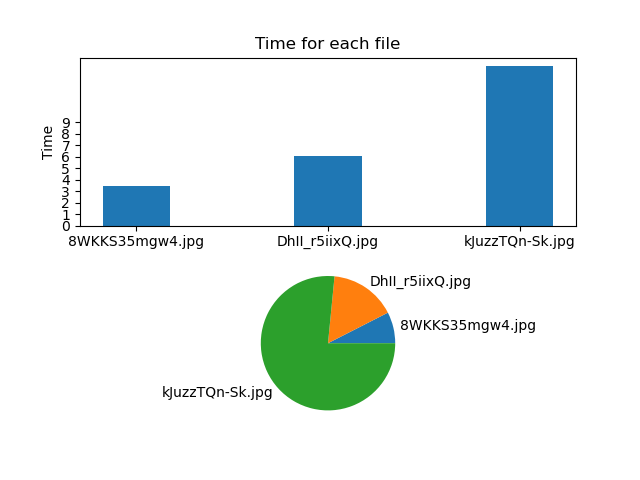

In [ ]:
%gui qt
%matplotlib notebook
import os
import threading
import Task5Window
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PyQt5 import QtCore, QtWidgets

class Task5(QtWidgets.QMainWindow):
    def __init__(self):
        QtWidgets.QMainWindow.__init__(self)
        self.ui = Task5Window.Ui_MainWindow()
        self.ui.setupUi(self)
        self.ui.pushButton.clicked.connect(self.start_downloading)
        self.datas = []
        
        
    def start_downloading(self):
        T1 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit, self.ui.progressBar))
        T2 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit_2, self.ui.progressBar_2))
        T3 = threading.Thread(target = self.threading_func, args=(self.ui.lineEdit_3, self.ui.progressBar_3))
        T1.start()
        T2.start()
        T3.start()
        T1.join()
        T2.join()
        T3.join()
        self.matplot_stuff()
    
    def matplot_stuff(self):
        N = len(self.datas)
        timeMeans = np.array([i.time_to_download for i in self.datas])
        ind = np.arange(N)
        width = 0.35
        plt.subplot(2, 1, 1)
        plt.bar(ind, timeMeans, width)
        plt.ylabel('Time')
        plt.title('Time for each file')
        plt.xticks(ind, ([i.filename for i in self.datas]))
        plt.yticks(np.arange(0, 10, 1))
        
        plt.subplot(2, 1, 2)
        labels = [i.filename for i in self.datas]
        sizes = [i.size for i in self.datas]
        plt.pie(sizes, labels=labels)
        plt.show()
        
    
          
    def threading_func(self, line_edit : QtWidgets.QLineEdit, progress_bar : QtWidgets.QProgressBar):
        data = DownloadData()
        if self.ui.lineEdit.text() != '':
            start = time()
            url = line_edit.text()
            r = requests.get(url, stream=True)
            filename = url.split('/')[-1]
            data.filename = filename
            total_length = int(r.headers.get('content-length'))
            data.size = total_length
            progress_bar.setMaximum(total_length)
            with open(filename, "wb") as f:
                i = 0
                for chunk in r.iter_content(4):
                    i += 4
                    f.write(chunk)
                    progress_bar.setValue(i)
            time_to_dl = time() - start
            data.time_to_download = time_to_dl
            progress_bar.setValue(total_length)
            self.datas.append(data)
            
            
class DownloadData():
    def __init__(self):
        filename = ""
        time_to_download = ""
        size = ""
        
if __name__ == '__main__':
    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = QtWidgets.QApplication(sys.argv)
    w = Task5()
    w.show()

    app.exec_()

6.С помощью модуля numPy реализуйте следующие операции: 1)
умножение произвольных матриц А (размерности 3х5) и В (5х2); 2)
умножение матрицы (5х3) на трехмерный вектор; 3) решение
произвольной системы линейных уравнений; 4) расчет определителя
матрицы; 5) получение обратной и транспонированной матриц.
Также продемонстрируйте на примере матрицы 5х5 тот факт, что
определитель равен произведению собственных значений матрицы

In [2]:
class MatrixActions():
    @staticmethod
    def multiply_matrix():
        print('1) ', end='')
        first_matrix = numpy.arange(3 * 5).reshape((3, 5))
        second_matrix = numpy.arange(5 * 2).reshape((5, 2))
        print('First matrix:\n', first_matrix)
        print('Second matrix:\n', second_matrix)
        print('Result of multiplication:\n', first_matrix @ second_matrix)

    @staticmethod
    def multiply_matrix_vector():
        print('2) ', end='')
        matrix = numpy.arange(2 * 3).reshape((3, 2))
        vector = numpy.array([1, -1], dtype=float)
        print('Matrix:\n', matrix)
        print('Vector:\n', vector)
        print('Result of multiplication:\n', matrix @ vector)

    @staticmethod
    def linear_equation_system():
        print('3) ', end='')
        print(' 11x + 33y = 131\n 42x - 28y = 96')
        matrix = numpy.array([[11., 33.], [42., -28.]])
        vector = numpy.array([131., 96.])
        print('Result:\n', numpy.linalg.solve(matrix, vector))

    @staticmethod
    def determinant():
        print('4) ', end='')
        matrix = numpy.arange(5 * 5).reshape((5, 5))
        print(det(matrix))

    @staticmethod
    def inverse_transposed():
        print('5)', end='')
        a = numpy.array([[6, 3, 5], [5, 2, 7], [7, 1, 6]])
        print('Matrix:\n', a)
        a_inversed = inv(a)
        print('Inversed matrix:\n', a_inversed)
        a_transposed = a.transpose()
        print('Transposed matrix:\n', a_transposed)

    @staticmethod
    def matrix_eigenvalues():
        print('6) ', end ='')
        a = numpy.array([[8, 4, 8], [7, 9, 4], [5, 2, 1]])
        print("Matrix:\n", a)
        q = eig(a)
        print("Matrix eigenvalues:\n", q[0])
        q_mult = numpy.prod(q[0])
        print("Their multiplication result: ", q_mult)
        d = det(a)
        print("Matrix determinant: ", d)
        
    @staticmethod
    def run_through_all():
        MatrixActions.multiply_matrix()
        MatrixActions.multiply_matrix_vector()
        MatrixActions.linear_equation_system()
        MatrixActions.determinant()
        MatrixActions.inverse_transposed()
        MatrixActions.matrix_eigenvalues()

        
if __name__ == '__main__':
    MatrixActions.run_through_all()

1) First matrix:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
Second matrix:
 [[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
Result of multiplication:
 [[ 60  70]
 [160 195]
 [260 320]]
2) Matrix:
 [[0 1]
 [2 3]
 [4 5]]
Vector:
 [ 1. -1.]
Result of multiplication:
 [-1. -1. -1.]
3)  11x + 33y = 131
 42x - 28y = 96
Result:
 [4.03541913 2.62455726]
4) 0.0
5)Matrix:
 [[6 3 5]
 [5 2 7]
 [7 1 6]]
Inversed matrix:
 [[ 0.11904762 -0.30952381  0.26190476]
 [ 0.45238095  0.02380952 -0.4047619 ]
 [-0.21428571  0.35714286 -0.07142857]]
Transposed matrix:
 [[6 5 7]
 [3 2 1]
 [5 7 6]]
6) Matrix:
 [[8 4 8]
 [7 9 4]
 [5 2 1]]
Matrix eigenvalues:
 [16.52483797  4.19023786 -2.71507583]
Their multiplication result:  -188.0000000000001
Matrix determinant:  -188.0


7.Выберите произвольную дифференцируемую и интегрируемую
функцию одной переменной. С помощью модуля symPy найдите и
отобразите ее производную и интеграл в аналитическом и
графическом виде. Напишите код для решения произвольного
нелинейного урванения и системы нелинейных уравнений.

Функция:  x**3
Derivative: 
   2
3⋅x 


<IPython.core.display.Javascript object>


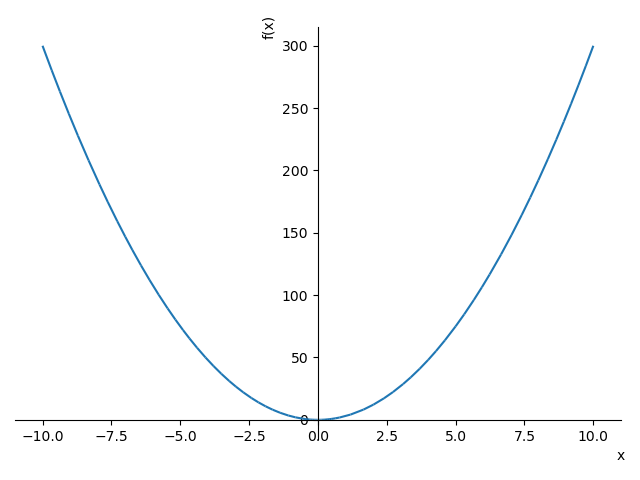


Integral: 
 4
x 
──
4 


<IPython.core.display.Javascript object>


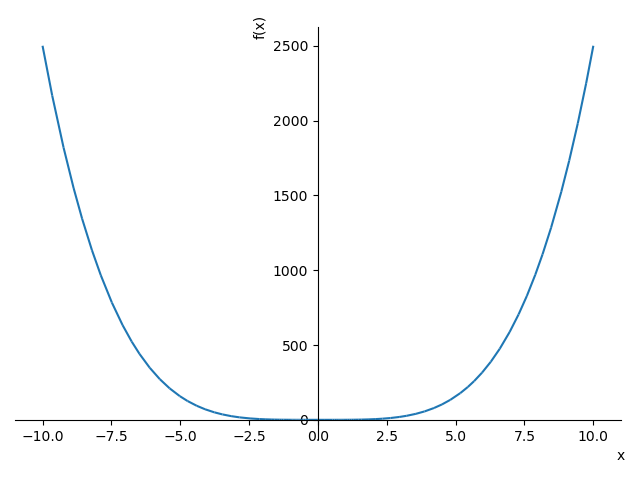

Equations system:

⎡                  ⎛-3⋅√2⋅ⅈ   √2⋅ⅈ⎞  ⎛3⋅√2⋅ⅈ  -√2⋅ⅈ ⎞⎤
⎢(-3, -2), (3, 2), ⎜────────, ────⎟, ⎜──────, ──────⎟⎥
⎣                  ⎝   2       2  ⎠  ⎝  2       2   ⎠⎦
Single equation:

[-2, 2]


In [3]:
%matplotlib notebook
import matplotlib
from sympy import *

def differentiation_and_integration():
    x = Symbol('x')
    func = x ** 3
    print('Функция: ', str(func))
    print('Derivative: ')
    differencial = diff(func)
    pprint(differencial)
    plot(differencial)
    print('\nIntegral: ')
    integral = integrate(func)
    pprint(integral)
    plot(integral)


def solving(*equations):
    if len(equations) == 1:
        return solve(equations[0])
    return solve_poly_system(equations)


def solve_equations():
    x, y = symbols('x y')
    equation1 = Equality(-9, x ** 2 - 3 * x * y)
    equation2 = Equality(-2, y ** 2 - x * y)
    equation3 = Equality(x ** 2, 4)
    print('Equations system:\n')
    pprint(solving(equation1, equation2))
    print('Single equation:\n')
    pprint(solving(equation3))


if __name__ == '__main__':
    differentiation_and_integration()
    init_printing()
    solve_equations()

8.Скачайте файл с информацией о всех государствах мира по адресу:
https://github.com/mledoze/countries/blob/master/dist/countries.csv. С
помощью модуля pandas отобразите: 1) 10 самых маленьких и самых
больших стран мира по территории; 2) 10 самых маленьких и самых
больших стран мира по населению; 3) все франкоязычные страны
мира; 4) только островные государства; 5) все страны, находящиеся
в южном полушарии. Сгруппируйте страны по первой букве; по
населению; по территории. Программно сохраните в таблицу Excel
все страны с выборочной информацией: название, столица,
население, территория, валюта, широта, долгота.

In [4]:
import csv
import pandas as pd
from pandas import read_csv

countries_file = 'countries.csv'

class WorkWithCSV:
    @staticmethod
    def save_to_excel(table):
        names = pd.Series([d.split(',')[0] for d in table.name])
        names.name = 'name'
        lat, lng = zip(*[d.split(',')
                         if isinstance(d, str)
                         else ['nan', 'nan']
                         for d in table.latlng])
        lat, lng = map(pd.Series, (lat, lng))
        lat.name = 'latitude'
        lng.name = 'longitude'
        for_export = pd.concat([names, table[['capital', 'ccn3', 'area', 'currencies']], lat, lng], axis=1)
        with pd.ExcelWriter('exported.xls') as excel_writer:
            for_export.to_excel(excel_writer)

            
    @staticmethod
    def show_info():
        table = read_csv(countries_file, ',')

        print('\nCountries with largest area\n')
        print(table.nlargest(n=10, columns='area')[['area', 'name']])  # 10 самых больших стран мира по территории
        print('\nCountries with smallest area\n')
        print(table.nsmallest(10, ['area'])[['area', 'name']])

        print('\nCountries with largest population\n')
        print(table.nlargest(10, ['ccn3'])[['ccn3', 'name']])  # 10 самых больших стран мира по населению
        print('\nCountries with smallest population\n')
        print(table.nsmallest(10, ['ccn3'])[['ccn3', 'name']])

        print('\nFrench speaking countries\n')
        print(table[table.languages == 'French'][['languages', 'area', 'name']])  # все франкоязычные страны мира

        print('\nCountries on islands\n')
        print(table[table.borders.isnull()][['name']])  # только государства-острова(ни с кем не граничат)
        save_to_excel(table=table)

        # все страны, находящиеся в южном полушарии
        print('\nCountries from Southern Hemisphere\n')
        print(table.where(pd.Series([float(str(d).split(',')[0]) < 0 for d in table.latlng])).name.dropna())

        for i, group in table.groupby(table.area):  # группировка по территории
        # for i, group in table.groupby(table.ccn3):  # группировка по населению
        # for i, group in table.groupby([d[0] for d in table.name]):  # Групировка по первой букве
            print(str(i) + ': ')
            for j, name in enumerate(group.name, 1):
                print(str(j) + '.', name.split(',')[0])


if __name__ == '__main__':
    WorkWithCSV.show_info()


Countries with largest area

           area                                               name
191  17098242.0  Russia,Russian Federation,Российская Федерация...
11   14000000.0                             Antarctica,Antarctica,
40    9984670.0          Canada,Canada,Canada,Canada,Canada,Canada
44    9706961.0        China,People's Republic of China,中华人民共和国,中国
235   9372610.0  United States,United States of America,United ...
33    8515767.0  Brazil,Federative Republic of Brazil,República...
14    7692024.0  Australia,Commonwealth of Australia,Commonweal...
105   3287590.0  India,Republic of India,Republic of India,Indi...
8     2780400.0  Argentina,Argentine Republic,Argentine Republi...
117   2724900.0  Kazakhstan,Republic of Kazakhstan,Қазақстан Ре...

Countries with smallest area

      area                                               name
198  -1.00  Svalbard and Jan Mayen,Svalbard og Jan Mayen,S...
237   0.44  Vatican City,Vatican City State,Stato della Ci...
140   2.02  Mona

NameError: name 'save_to_excel' is not defined